In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/rupertmenneer/Documents/git/bayesian_flow/')
from datasets.bfn_discretised_toy_data import DiscretisedBimodalData
from discretised.bfn_discretised import BayesianFlowNetworkDiscretised
from models.simple_models import SimpleNeuralNetworkDiscretised
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD, AdamW
import matplotlib.pyplot as plt
import torch
torch.set_printoptions(precision=5, sci_mode=False)
k = 5
dataset = DiscretisedBimodalData(n=10000, k=k)
dataloader = DataLoader(dataset, batch_size=10000, shuffle=True, drop_last=True)
batch = next(iter(dataloader))

torch.Size([10000, 1])


(array([1821., 3153.,   58., 3436., 1532.]),
 array([-0.80000001, -0.48000002, -0.16000003,  0.15999997,  0.47999996,
         0.79999995]),
 <BarContainer object of 5 artists>)

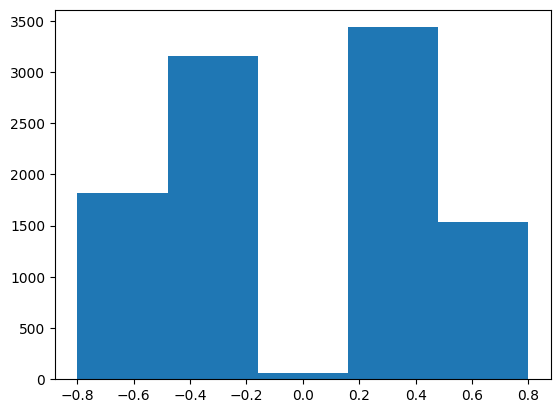

In [3]:
print(batch.shape)
plt.hist(batch.squeeze(), bins=k)

In [4]:
from torch_ema import ExponentialMovingAverage

device = 'cpu'
bfn_model = BayesianFlowNetworkDiscretised(SimpleNeuralNetworkDiscretised(), device=device, k=k).to(device)
optim = AdamW(bfn_model.parameters(), lr=3e-4, betas=(0.9, 0.98), weight_decay=0.01)

ema = ExponentialMovingAverage(bfn_model.parameters(), decay=0.995)
torch.autograd.set_detect_anomaly(True)
epochs = 5000
losses = []
n_batches_track = 100
n = 400
for i in range(epochs):
    # print(i)
    epoch_losses = []
    for _, batch in enumerate(dataloader):
        optim.zero_grad()
        loss = bfn_model.discrete_time_loss_for_discretised_data(batch.to(device), n=n)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(bfn_model.parameters(), max_norm=2.0)
        optim.step()
        # Update the moving average with the new parameters from the last optimizer step
        ema.update()
        epoch_losses.append(loss.item())
    if i%n_batches_track == 0:
        print(f'Epoch {i+1}/{epochs}, Loss: {torch.mean(torch.tensor(epoch_losses))}')
    losses.append(torch.mean(torch.tensor(epoch_losses)))



Epoch 1/5000, Loss: 2.175971746444702
Epoch 101/5000, Loss: 1.6980433464050293
Epoch 201/5000, Loss: 1.6983622312545776
Epoch 301/5000, Loss: 1.6853580474853516
Epoch 401/5000, Loss: 1.7789654731750488
Epoch 501/5000, Loss: 1.7400851249694824
Epoch 601/5000, Loss: 1.7403123378753662
Epoch 701/5000, Loss: 1.8192996978759766
Epoch 801/5000, Loss: 1.5539536476135254
Epoch 901/5000, Loss: 1.6958481073379517
Epoch 1001/5000, Loss: 1.6095329523086548
Epoch 1101/5000, Loss: 1.5598936080932617
Epoch 1201/5000, Loss: 1.546764612197876
Epoch 1301/5000, Loss: 1.5057517290115356
Epoch 1401/5000, Loss: 1.7340853214263916
Epoch 1501/5000, Loss: 1.6011874675750732
Epoch 1601/5000, Loss: 1.597758412361145
Epoch 1701/5000, Loss: 1.448236346244812
Epoch 1801/5000, Loss: 1.347784399986267
Epoch 1901/5000, Loss: 1.6879938840866089
Epoch 2001/5000, Loss: 1.467816948890686
Epoch 2101/5000, Loss: 1.6377739906311035
Epoch 2201/5000, Loss: 1.233526587486267
Epoch 2301/5000, Loss: 1.4206384420394897
Epoch 2401/

In [ ]:
print(batch.shape)
plt.hist(batch.squeeze(), bins=k)

Text(0.5, 1.0, 'Training loss')

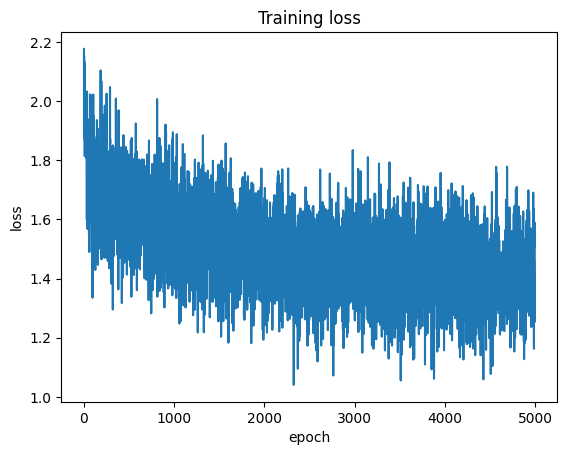

In [11]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training loss')

# Sample generation

In [ ]:
torch.randint(1, 25, (32, 1))

In [12]:
k=5
bs=1000
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)
batch = next(iter(dataloader))
print(len(torch.unique(batch)))
samples, priors = bfn_model.sample_generation_for_discretised_data(sample_shape=(bs, 1), n_steps=100)
samples = samples.to(torch.float32)
print(len(torch.unique(samples)))

5
5


tensor([-0.80000, -0.40000,  0.00000,  0.40000,  0.80000])


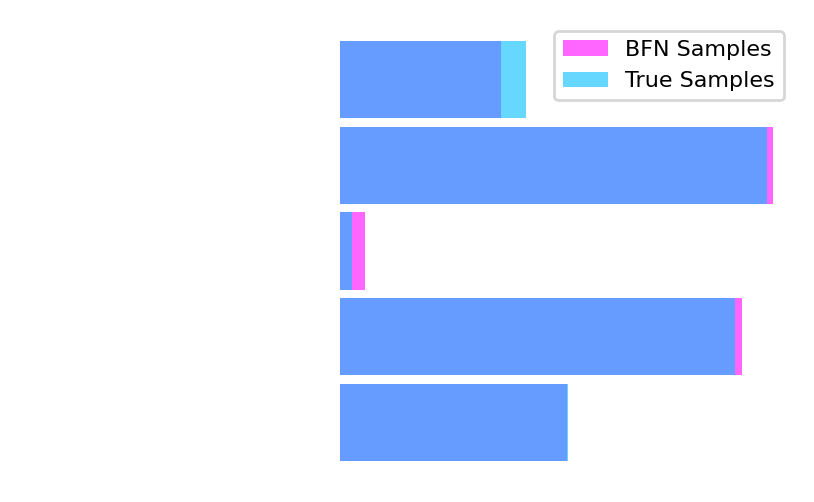

In [122]:
k=5
plt.figure(figsize=(5, 3), dpi=200)
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)
batch = next(iter(dataloader))
batch.shape
n_steps = 100
with ema.average_parameters():
    samples, priors = bfn_model.sample_generation_for_discretised_data(sample_shape=(bs, 1), n_steps=n_steps)
    samples = samples.to(torch.float32)

plt.hist(samples.detach().numpy(), alpha=0.6, bins=k, label='BFN Samples', color='fuchsia', density = True, orientation='horizontal', rwidth=0.9)
plt.hist(batch.numpy(), bins=k, alpha=0.6, color='deepskyblue', label='True Samples', density = True, orientation='horizontal', rwidth=0.9)

# plt.title('Samples from Discretised BFN model')
# plt.yticks([0, ])
# Assuming `ax` is your histogram's axis
ax = plt.gca()  # Get the current axis
import matplotlib.ticker as mtick
# Set the y-axis major formatter to convert to percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
print(bfn_model.k_centers)
plt.xticks(bfn_model.k_centers)
plt.legend(loc='upper right', fontsize=8)

plt.axis('off')
# Rotate the plot 90 degrees

plt.show()


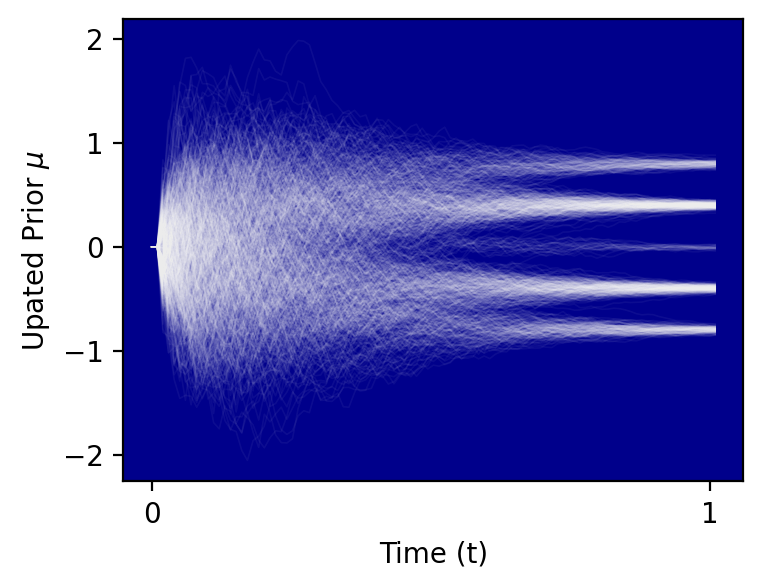

In [35]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)

ax.set_facecolor('darkblue')
# ax.set_facecolor((1.0, 0.47, 0.42))
# n_samples = 300
plt.plot(priors.detach().numpy()[:, :, 0, :].squeeze().T, label='Prior mu', alpha=0.05, color='white', linewidth=0.6);
plt.xlabel('Generation step')
plt.ylabel(r'Upated Prior $\mu$')
# plt.title('Mean samples over time from Discretised BFN model')
ax.set_xlabel('Time (t)')
ax.set_xticks([0, n_steps-1], ['0', '1'])

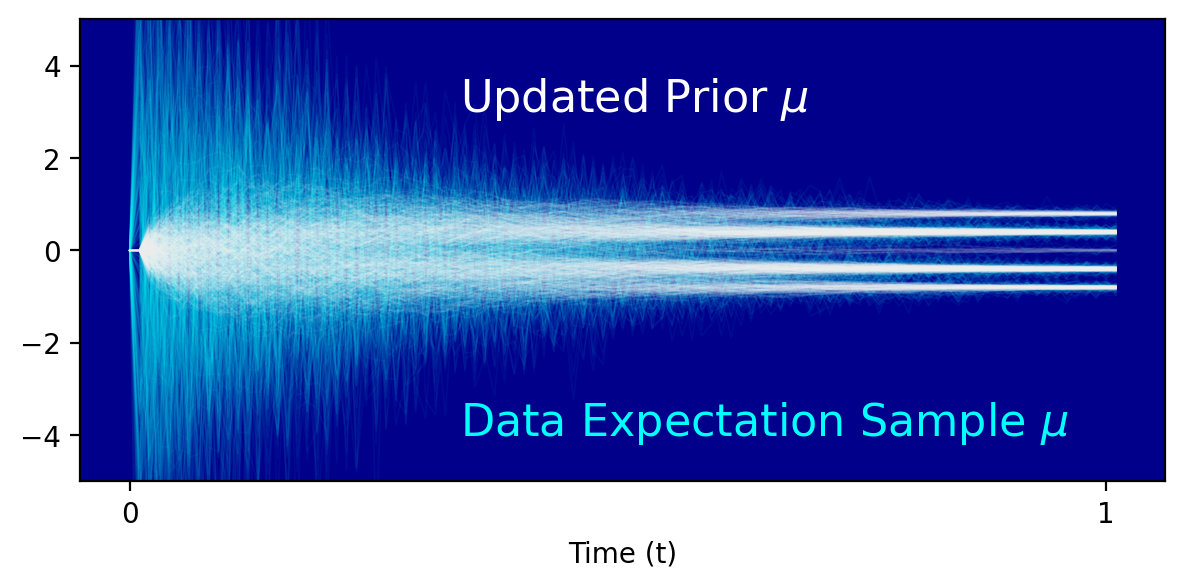

In [124]:
fig, ax = plt.subplots(figsize=(7, 3), dpi=200)

ax.set_facecolor('darkblue')
# ax.set_facecolor((1.0, 0.47, 0.42))
n_samples = 300
plt.plot(priors.detach().numpy()[:n_samples, :, 2, :].squeeze().T, label='Noisy sample', alpha=0.05, color='cyan', linewidth=0.6);
plt.plot(priors.detach().numpy()[:, :, 0, :].squeeze().T, label='Prior mu', alpha=0.05, color='white', linewidth=0.6);
plt.xlabel('Generation step')
# plt.ylabel(r'Data Expectation Sample $\mu$')
# plt.title('Mean samples over time from Discretised BFN model')
ax.set_ylim(-5, 5)

# plt.legend([r'Data Expectation Sample $\mu$', r'Prior $\mu$'], loc='upper right', fontsize=8)
plt.text(0.35, 0.1, r'Data Expectation Sample $\mu$', fontsize=16, color='cyan', transform=ax.transAxes)
plt.text(0.35, 0.8, r'Updated Prior $\mu$', fontsize=16, color='white', transform=ax.transAxes)
ax.set_xlabel('Time (t)')
ax.set_xticks([0, n_steps-1], ['0', '1'])

In [17]:
torch.max(priors)

tensor(11.10582)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import torch

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    x = torch.tensor(x)
    return torch.softmax(x, dim=0)

def line_heatmap(data, sigma=10.0):
    """
    Generate a heatmap representation of multiple line plots.

    Parameters:
    - data: a 2D numpy array of shape [batch, time]
    - sigma: the standard deviation for the Gaussian filter

    Returns:
    - A 2D numpy array representing the heatmap.
    """

    # Determine the span of the line data
    min_val, max_val = data.min(), data.max()
    spanned_space = np.linspace(min_val, max_val, num=500)  # Adjust the resolution as needed
    heatmap = np.zeros((spanned_space.size, data.shape[1]))

    # Iterate over each batch and time to populate the heatmap
    for batch in range(data.shape[0]):
        for time in range(data.shape[1]):
            # Find the closest index in spanned_space for the current line value
            index = np.abs(spanned_space - data[batch, time]).argmin()
            s=3
            heatmap[index-s:index+s, time] += 1

    # heatmap = np.log(heatmap+1)
    # max_heatmap = np.max(heatmap)
    # heatmap = heatmap / max_heatmap
    # Apply Gaussian filter to smooth the heatmap
    # smoothed_heatmap = gaussian_filter(heatmap, sigma=sigma, axes=0)
    # smoothed_heatmap = gaussian_filter(heatmap, sigma=sigma)
    smoothed_heatmap =heatmap

    return smoothed_heatmap

n_lines = priors.detach().numpy()[:, :, 0, :].squeeze()

heatmap = line_heatmap(n_lines)

# # Plotting the lines with heatmap background
# plt.figure(figsize=(6, 3), dpi=200)
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)

time = np.arange(n_lines.shape[1])
# # Generate the density heatmap
heatmap = gaussian_filter(heatmap, sigma=3.0)
extent = [time.min(), time.max(), n_lines.min(), n_lines.max()]

# # Plot the heatmap
ax.imshow(heatmap, extent=extent, origin='lower', aspect='auto', cmap='jet')

# Plot the lines on top of the heatmap
n_samples = 2
rand_idxs = np.random.randint(0, n_lines.shape[0], n_samples)
print(n_lines.shape)
for i in rand_idxs:
    ax.plot(time, n_lines[i, :], color='white', linewidth=1)

# Customizing the plot to look similar to the image
ax.set_xlabel('Time (t)')
ax.set_xticks([0, len(time)-1], ['0', '1'])
# ax.set_ylim([n_lines.min(), n_lines.max()])

plt.show()
